# Metalens Studies Automation
written by: Taylor Contreras, Feb 5 2021

This code controls the automation of the oscilliscope and the motors to take measurements of the light intensity of a SiPM. An LED is aligned with a diffraction grating in front of the SiPM. The SiPM and LED are on tracks that can move vertically. This allows the calibration of the SiPM with no light and for the measurement of light intensity as a function of angle from the diffraction grating. 

See other notebooks for more details and tests (PyVisa_tutorial.ipynb, Ardruino_testing.ipynb, Motot_control_testing.ipynb)

In [3]:
from motor import Motor
import oscilloscope as osc
from metalens_experiment import Experiment
import matplotlib.pyplot as plt

from IPython.display import display, clear_output
import csv

import pyvisa
import pyfirmata

### Connect to the oscilliscope

In [4]:
# Before running, connect the laptop to the oscilloscope through the USBTMC
rm = pyvisa.ResourceManager()
# Use the name this prints to grab the instrument in the next step
rm.list_resources() 

('USB0::0x05FF::0x1023::4206N21552::INSTR',
 'ASRL3::INSTR',
 'ASRL4::INSTR',
 'ASRL7::INSTR',
 'ASRL10::INSTR',
 'ASRL12::INSTR')

In [5]:
# Grabs the instrument and prints name
scope = rm.open_resource('USB0::0x05FF::0x1023::4206N21552::INSTR')

### Connect to the Arduino

In [6]:
# Use Arduino IDE to find the port name
# under Tools->Port
# This time is was COM3
board1 = pyfirmata.Arduino('COM3')
#board2 = pyfirmata.Arduino('COM6')

# must set iterator in order to take input (the button)
# make sure to run only once
it1 = pyfirmata.util.Iterator(board1)
it1.start()
#it2 = pyfirmata.util.Iterator(board2)
#it2.start()

### Make 'exp' to hold all the experiment objects and variables

In [7]:
# Creat sipm and led motor class objects
sipm_step_pin = 8
sipm_dir_pin = 9
sipm_button_pin = 6
led_step_pin = 10
led_dir_pin = 11
led_button_pin = 5
rot_step_pin = 10
rot_dir_pin = 11
lens_step_pin = 12
lens_dir_pin = 13
lens_button_pin = 5
board1.digital[sipm_button_pin].mode = pyfirmata.INPUT
board1.digital[lens_button_pin].mode = pyfirmata.INPUT
sipm_motor = Motor(board1, sipm_step_pin, sipm_dir_pin, 'sipm', sipm_button_pin) # pos dir is toward motor
led_motor = Motor(board1, led_step_pin, led_dir_pin, 'led') # pos dir is up
rot_motor = Motor(board1, rot_step_pin, rot_dir_pin, 'rot')
lens_motor = Motor(board1, lens_step_pin, lens_dir_pin, 'lens', lens_button_pin) # pos dir is toward motor

#sipm_motor.CreatePositionFile()
#led_motor.CreatePositionFile()

In [8]:
exp = Experiment(rot_motor, lens_motor, led_motor, sipm_motor, scope)

In [9]:
exp.PrintInfo()

---Experiment---
Motor name: lens
    Step pin: 12
    Dir pin: 13
    Button pin: 5
    Center: 155.37
    Diam: 9.8
Motor name: sipm
    Step pin: 8
    Dir pin: 9
    Button pin: 6
    Center: 117.37
Motor name: rot
    Step pin: 10
    Dir pin: 11
    Button pin: 0
    Center: 0
LED motor off
Oscilloscope: *IDN LECROY,WAVERUNNER8054,LCRY4206N21552,8.5.1

    Number of Sweeps: 15


In [22]:
exp.Align()

LED motor is off. Switch motors to align


### Aligning Lens, SiPM, LED

Use these funtions if the setup seems to be out of alignment or if you have replaced any pieces. 

#### Find alignment of SiPM and LED (no lens)

'100/100'

Old SiPM center = 117.37
New SiPM center = 117.565


Text(0, 0.5, 'Peak to Peak voltage [V]')

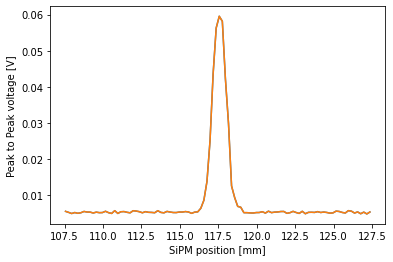

In [16]:
width=20.
num_measurements=100
position_led, positions_sipm, maxes = exp.FindSiPMCenter(width, num_measurements)
plt.plot(positions_sipm, maxes)
plt.xlabel('SiPM position [mm]')
plt.ylabel('Peak to Peak voltage [V]')

#### Find Mount Center

'200/200'

Text(0, 0.5, 'Peak to Peak voltage [V]')

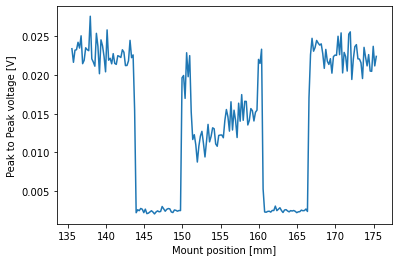

In [59]:
scan_width = 40
num_measurements = 200
positions_lens, maxes = exp.ScanLens(scan_width, num_measurements)
plt.plot(positions_lens, maxes)
plt.xlabel('Mount position [mm]')
plt.ylabel('Peak to Peak voltage [V]')

In [60]:
# Find edges of mount to find diameter of the mount
peak_width=4
prominence=0.015
exp.FindMountCenter(positions_lens, maxes, peak_width, prominence)

Lens edges 143.76 149.76
Lens edges 160.36 166.36
Mount diameter = 10.600000000000023
Mount center = 155.06


#### Find center of Lens in x

'400/400'

Text(0, 0.5, 'Peak to Peak voltage [V]')

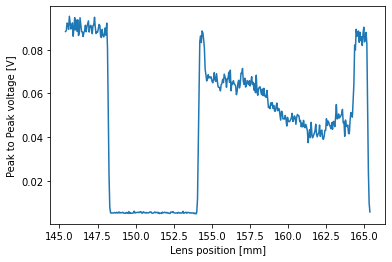

In [23]:
width=20.
num_measurements=400
positions_lens, maxes = exp.ScanLens(width, num_measurements)
plt.plot(positions_lens, maxes)
plt.xlabel('Lens position [mm]')
plt.ylabel('Peak to Peak voltage [V]')

In [26]:
exp.lens_motor.MoveMotor(5)

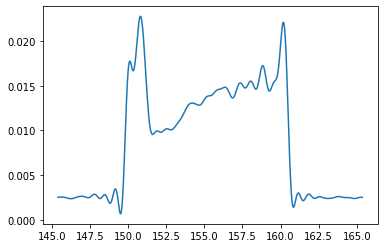

In [70]:
plt.plot(positions_lens, smoothed_maxes)

In [24]:
prominence = 0.010
exp.FindLensCenter(positions_lens, maxes, prominence)

NameError: name 'prominence_peaks' is not defined

In [73]:
exp.Align()

In [ ]:
# Try to find derivative rather than peaks
der = np.diff(maxes) / np.diff(positions_lens)
positions_lens2 = (positions_lens[:-1] + positions_lens[1:]) / 2
plt.plot(positions_lens2, der, 'r', positions_lens, maxes, 'g')

#### Find LED center

In [74]:
led_scan_width = 8.
lens_scan_width = 10.
num_measurements_led = 50
num_measurements_lens = 100
led_data = exp.ScanLED(led_scan_width, lens_scan_width, num_measurements_led, num_measurements_lens)

'100/100'

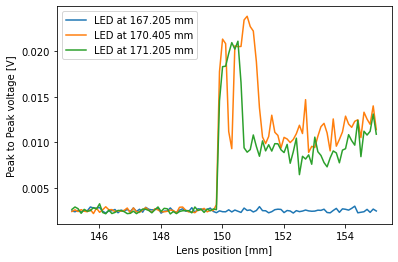

In [75]:
# Plot the spectrum in the ~middle of the lens and at +/- an offset
half = len(led_data)//2
offset = 20
positions_lens = led_data[half-offset][0]
maxes = led_data[half-offset][1]
led_position = led_data[half-20][2]
plt.plot(positions_lens, maxes, label='LED at '+str(led_position)+' mm')

positions_lens = led_data[half][0]
maxes = led_data[half][1]
led_position = led_data[half][2]
plt.plot(positions_lens, maxes, label='LED at '+str(led_position)+' mm')

positions_lens = led_data[half+offset][0]
maxes = led_data[half+offset][1]
led_position = led_data[half+5][2]
plt.plot(positions_lens, maxes, label='LED at '+str(led_position)+' mm')
plt.xlabel('Lens position [mm]')
plt.legend()
plt.xlabel('Lens position [mm]')
plt.ylabel('Peak to Peak voltage [V]')
plt.show()

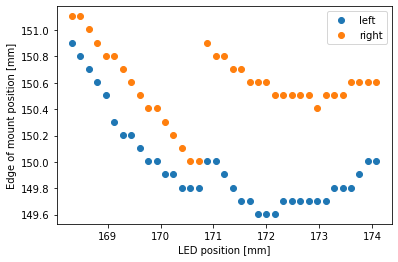

Old LED center = 170.41
New LED center = 171.845


In [76]:
prominence = 0.01
exp.FindLEDCenter(led_data, prominence)

#### Use this code if the data is particulalry noisy and you are having trouble finding peaks

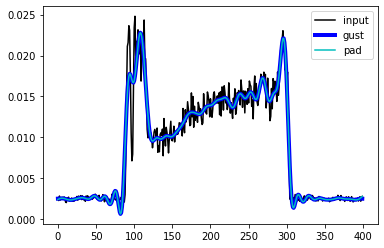

In [68]:
from scipy import signal
b, a = signal.ellip(6, 0.01, 120, 0.125)  # Filter to be applied.
fgust = signal.filtfilt(b, a, maxes, method="gust")
fpad = signal.filtfilt(b, a, maxes, padlen=50)
plt.plot(maxes, 'k-', label='input')
plt.plot(fgust, 'b-', linewidth=4, label='gust')
plt.plot(fpad, 'c-', linewidth=1.5, label='pad')
plt.legend(loc='best')
plt.show()

smoothed_maxes = fgust

### Aligning rotation of lens

In [27]:
from IPython.display import display, clear_output
def ScanRotation(scan_degrees, num_steps, width_lens=20., num_measurements_lens=200):
    dtheta = scan_degrees/num_steps
    if dtheta < 1.8/8.:
        print('Too small of steps. Minimum degrees per step is '+str(1.8/4.))
        return
    exp.rot_motor.Rotate(-scan_degrees/2.)
    rot_data = []
    for step in range(num_steps):
        clear_output(wait=True)
        display(str(step+1)+"/"+str(num_steps))
        exp.rot_motor.Rotate(dtheta)
        positions_lens, maxes = exp.ScanLens(width_lens, num_measurements_lens)
        rot_data.append([positions_lens, maxes, exp.rot_motor.GetCurrentNumSteps()])
    exp.rot_motor.Rotate(-scan_degrees/2.)
    
    return rot_data

In [32]:
rot_data = ScanRotation(70, 10, 20, 100)

'100/100'

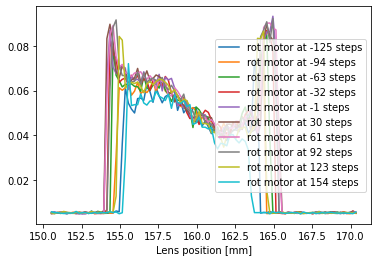

In [33]:
for rot in rot_data:
    plt.plot(rot[0], rot[1], label='rot motor at '+str(rot[2])+' steps')
plt.xlabel('Lens position [mm]')
plt.legend()

In [48]:
import numpy as np
from scipy import signal
rot_data = np.array(rot_data)

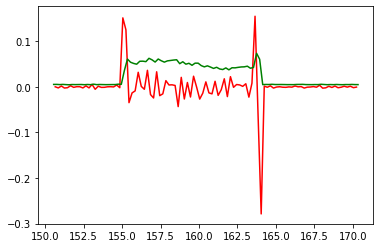

In [41]:
# Try to find derivative rather than peaks
der = np.diff(rot_data[0][1]) / np.diff(rot_data[0][0])
positions_lens2 = (np.array(rot_data[0][0][:-1]) + np.array(rot_data[0][0][1:])) / 2
plt.plot(positions_lens2, der, 'r', rot_data[0][0], rot_data[0][1], 'g')

In [63]:
peaks, _ = signal.find_peaks(der)
widths = signal.peak_widths(der, peaks)

In [64]:
widths

(array([0.97463768, 1.23537717, 1.75301205, 0.99285714, 0.88977843,
        0.68957346, 1.51428571, 1.20384615, 1.83789807, 1.05806453,
        1.51914681, 1.04815951, 3.69667106, 0.625     , 0.87024048,
        0.93916519, 1.59418817, 1.07439994, 1.06002331, 1.30851064,
        1.47440074, 1.67197575, 0.82341867, 1.12625351, 0.50424361,
        1.28282828, 1.63888889, 0.78333333, 3.17875   , 0.575     ,
        1.24137931, 1.2406015 , 0.88207547, 1.09473684, 0.94852941,
        1.30327869]),
 array([-4.82770338e-05,  2.57477514e-04, -1.60923446e-04,  1.28738757e-04,
         1.59314211e-03,  3.54031581e-04,  3.05754547e-04,  1.30347991e-03,
         7.33006296e-02,  1.35336618e-02,  1.01381771e-03,  4.55413352e-03,
        -2.65523686e-03,  4.52194883e-03, -2.70351389e-03, -6.16336798e-03,
        -1.54486508e-03, -2.02763542e-03, -3.04145313e-03, -1.60923446e-03,
         1.12646412e-04,  3.34720768e-03,  3.10582251e-03,  5.60818209e-02,
         5.14955027e-04,  1.60923446e-05, -1.9

In [62]:
print(rot_data[0][0][int(widths[2][0])],rot_data[0][0][int(widths[3][0])])

155.95000000000002 158.95000000000002


In [ ]:
# I should try to rotate, then scan maxes to get lens width and center
# then rotate again, so I see the center position moving
# since the metalens can be off center from the axis of rotation

In [10]:
exp.rot_motor.Rotate(90.)

### Testing and adjusting variables

In [ ]:
exp.sipm_motor.MoveMotor(10)
exp.sipm_motor.MoveMotor(-10)
exp.led_motor.MoveMotor(10)
exp.led_motor.MoveMotor(-10)
#exp.rot_motor.MoveMotor(10)
#exp.rot_motor.MoveMotor(-10)

In [9]:
osc.MeasurePeaktoPeak(scope, 15)

0.0167566368754706

In [ ]:
exp.sipm_motor.GetCurrentPosition()

In [ ]:
position_led, positions_sipm, maxes = exp.ScanMaxes(width=30., num_measurements=20)
plt.plot(positions_sipm, maxes)

# Runs

'200/200'

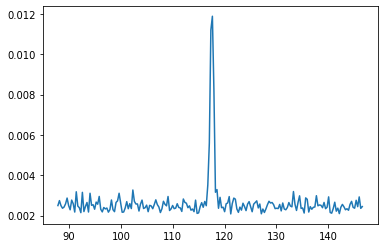

In [77]:
exp.Align()
position_led, positions_sipm, maxes = exp.ScanMaxes(width=60., num_measurements=200)
plt.plot(positions_sipm, maxes)

'200/200'

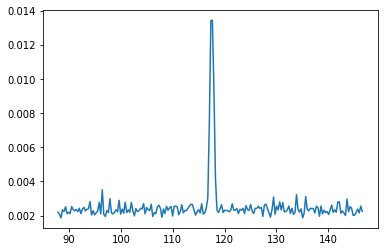

In [13]:
exp.Align()
position_led, positions_sipm, maxes = exp.ScanMaxes(width=60., num_measurements=200)
plt.plot(positions_sipm, maxes)

'200/200'

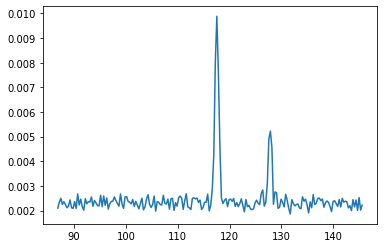

In [14]:
exp.Align()
exp.lens_motor.MoveMotor(4)
position_led, positions_sipm, maxes = exp.ScanMaxes(width=60., num_measurements=200)
plt.plot(positions_sipm, maxes)

'200/200'

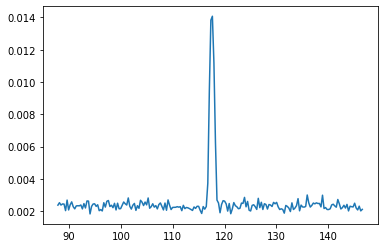

In [16]:
exp.Align()
exp.lens_motor.MoveMotor(-4)
position_led, positions_sipm, maxes = exp.ScanMaxes(width=60., num_measurements=200)
plt.plot(positions_sipm, maxes)

In [37]:
exp.Align()
exp.lens_motor.MoveMotor(3)
position_led, positions_sipm, maxes = exp.ScanMaxes(width=60., num_measurements=200)
plt.plot(positions_sipm, maxes)
plt.xlabel('SiPM Position [mm]')
plt.show()

'66/200'

KeyboardInterrupt: 

'200/200'

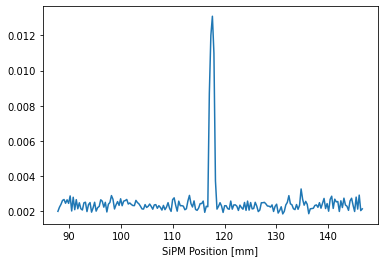

In [21]:
exp.Align()
exp.lens_motor.MoveMotor(-3)
position_led, positions_sipm, maxes = exp.ScanMaxes(width=60., num_measurements=200)
plt.plot(positions_sipm, maxes)
plt.xlabel('SiPM Position [mm]')
plt.show()

In [79]:
# Running over many lens positions to check lens symmetry
lens_scan_width = 5. # mm (lens radius)
num_scans = 10
base_file_name = '_metalens_100ns_15sweeps.csv'
run_num = 24
dx_lens = lens_scan_width / num_scans
lens_pos = 0.0
for i in range(num_scans):
    exp.Align()
    exp.lens_motor.MoveMotor(dx_lens*i)
    position_lens = exp.lens_motor.GetCurrentPosition()
    position_led, positions_sipm, maxes = exp.ScanMaxes(width=60., num_measurements=200)
    file_name = 'run'+str(run_num)+base_file_name
    SaveScanMaxesData(file_name, position_lens, position_led, positions_sipm, maxes)
    run_num += 1
    
    exp.Align()
    exp.lens_motor.MoveMotor(-dx_lens*i)
    position_lens = exp.lens_motor.GetCurrentPosition()
    position_led, positions_sipm, maxes = exp.ScanMaxes(width=60., num_measurements=200)
    file_name = 'run'+str(run_num)+base_file_name
    SaveScanMaxesData(file_name, position_lens, position_led, positions_sipm, maxes)
    run_num += 1

'200/200'

In [38]:
exp.Align()

In [17]:
lens_motor.MoveMotor(-2)

'200/200'

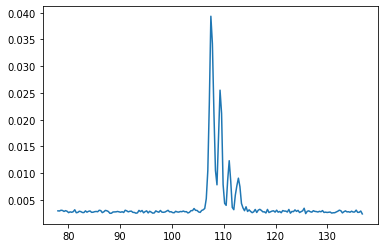

In [15]:
position_led, positions_sipm, maxes = exp.ScanMaxes(width=60., num_measurements=200)
plt.plot(positions_sipm, maxes)

In [21]:
lens_motor.GetCurrentPosition()
lens_motor.MoveMotor(-2)

'200/200'

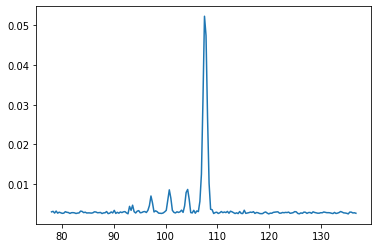

In [22]:
position_led, positions_sipm, maxes = exp.ScanMaxes(width=60., num_measurements=200)
position_lens = lens_motor.GetCurrentPosition()
plt.plot(positions_sipm, maxes)

'180/180'

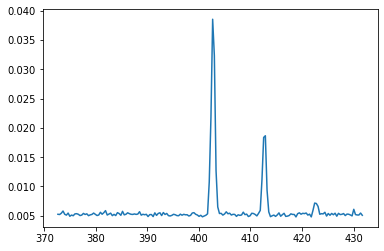

In [56]:
# Measure voltage at each distance
width = 60
num_measurements = 180
num_sweeps = 10
distance_to_move = width/num_measurements
maxes = []
positions_sipm = []
position_led = led_motor.GetCurrentPosition()
sipm_motor.MoveMotor(-width/2.)
for i in range(num_measurements):
    clear_output(wait=True)
    display(str(i+1)+"/"+str(num_measurements))
    sipm_motor.MoveMotor(distance_to_move)
    maxes.append(osc.MeasurePeaktoPeak(scope, num_sweeps))
    positions_sipm.append(sipm_motor.GetCurrentPosition())
sipm_motor.MoveMotor(-width/2.)
plt.plot(positions_sipm, maxes)

### Saving Data

In [78]:
file_name = 'run03_metalens_100ns_10sweeps.csv'
def SaveScanMaxesData(file_name, position_lens, position_led, positions_sipm, maxes):
    with open('data/'+file_name, mode='w') as file:
                writer = csv.writer(file)

                writer.writerow(['position_lens'])
                writer.writerow([position_lens]) 
                writer.writerow(['position_led'])
                writer.writerow([position_led])
                writer.writerow(['positions_sipm'])
                writer.writerow(positions_sipm)
                writer.writerow(['maxes'])
                writer.writerow(maxes)

# Close after done running

In [ ]:
# Make sure to close the connection (in teh reverse order of setting it up)
scope.close()
rm.close()